In [1]:

import os
import pickle
import numpy as np
from PIL import Image
import trimesh
import open3d
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from pose_estimation.icp import icp
from pose_estimation import PoseData, PoseDataNPZ, PoseDataNPZTorch, COLOR_PALETTE
from pose_estimation.utils import back_project, show_points, compare_points, compute_rre, compute_rte, \
    crop_and_resize, crop_and_resize_multiple

WORKDIR = f"{os.getcwd()}/.."
DATA_FOLDER = os.path.join(WORKDIR, "data_folder")

MODELS_PATH = os.path.join(DATA_FOLDER, "models")
TRAIN_PATH = os.path.join(DATA_FOLDER, "training_data")
TEST_PATH = os.path.join(DATA_FOLDER, "testing_data")

TRAIN_NPZ_PATH = os.path.join(DATA_FOLDER, "dataset_npz")
TEST_NPZ_PATH = os.path.join(DATA_FOLDER, "dataset_npz_test")


In [2]:
source_banana = trimesh.load(f"{DATA_FOLDER}/banana.source.ply").vertices
target_banana = trimesh.load(f"{DATA_FOLDER}/banana.target.ply").vertices
gt_banana = np.loadtxt(f"{DATA_FOLDER}/banana.pose.txt")

RUN_ICP_SANITY = False
if RUN_ICP_SANITY:
    iterations = 20
    attempts = 10
    # Visualization
    T = icp(source_banana, target_banana, attempts=10)
    rre = np.rad2deg(compute_rre(T[:3, :3], gt_banana[:3, :3]))
    rte = compute_rte(T[:3, 3], gt_banana[:3, 3])
    print(f"rre={rre}, rte={rte}")
    compare_points(source_banana @ T[:3, :3].T + T[:3, 3], target_banana)


[505 505 504 504 504 504 504 504 504 503 503 503 503 504 504 504 504 504
 504 504 503 503 503 503 503 503 503 502 502 502 502 502 502 504 504 503
 503 503 503 503 503 502 502 502 502 502 502 502 502 501 501 501 501 501
 501 501 503 503 503 502 502 502 502 502 502 502 501 501 501 501 501 501
 501 501 500 500 500 500 500 500 500 500 502 502 502 502 501 501 501 501
 501 501 501 500 500 500 500 500 500 500]
[505 505 504 504 504 504 504 504 504 503 503 503 503 504 504 504 504 504
 504 504 503 503 503 503 503 503 503 502 502 502 502 502 502 504 504 503
 503 503 503 503 503 502 502 502 502 502 502 502 502 501 501 501 501 501
 501 501 503 503 503 502 502 502 502 502 502 502 501 501 501 501 501 501
 501 501 500 500 500 500 500 500 500 500 502 502 502 502 501 501 501 501
 501 501 501 500 500 500 500 500 500 500]


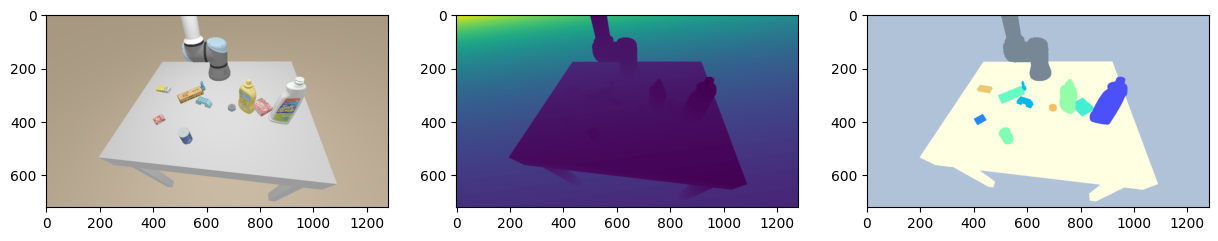

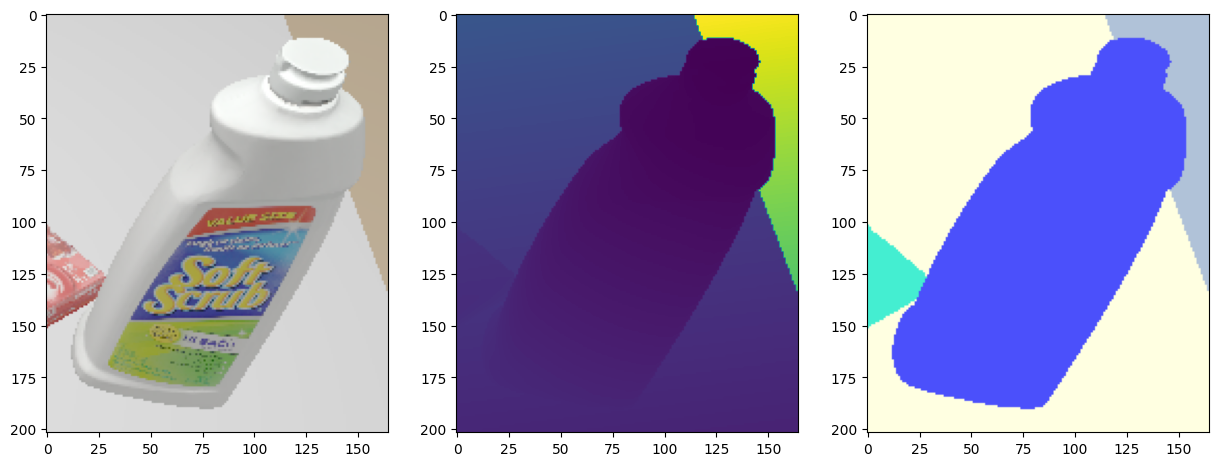

In [3]:

data = PoseData(TRAIN_PATH, MODELS_PATH)

scene = data[2, 1, 1]
rgb = scene["color"]()
depth = scene["depth"]()
label = scene["label"]()
meta = scene["meta"]

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.subplot(1, 3, 2)
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

mask = label == np.unique(label)[0]
target_size = None
margin = 12
aspect_ratio = False
mask_fill = False

(rgb_cr, depth_cr, label_cr, mask_cr), scale, translate = crop_and_resize_multiple(
    (rgb, depth, COLOR_PALETTE[label], mask), mask, target_size=target_size, margin=margin, 
    aspect_ratio=aspect_ratio, mask_fill=mask_fill)


print(depth[mask][:100])
print(depth_cr[mask_cr][:100])

plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(rgb_cr)
plt.subplot(1, 3, 2)
plt.imshow(depth_cr)
plt.subplot(1, 3, 3)
plt.imshow(label_cr)  # draw colorful segmentation


None None
['bleach_cleanser', 'cracker_box', 'e_lego_duplo', 'e_toy_airplane', 'gelatin_box', 'jenga', 'master_chef_can', 'mustard_bottle', 'sugar_box', 'tuna_fish_can']
[[ 9.80523229e-01  1.96401339e-01  8.43774207e-04  1.21868061e-01]
 [-1.96401693e-01  9.80523455e-01  3.58923180e-04  3.40061125e-01]
 [-7.56847407e-04 -5.17651198e-04  9.99999580e-01  1.26435341e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.8047554e-01  1.9664109e-01  5.3635486e-05  1.2149275e-01]
 [-1.9664109e-01  9.8047554e-01  1.9184829e-04  3.4023872e-01]
 [-1.4863028e-05 -1.9864950e-04  1.0000000e+00  1.2578414e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

rre=0.04657389253775037, rte=0.0007723048286905911


AssertionError: 

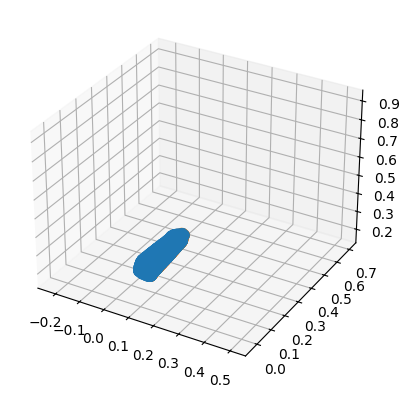

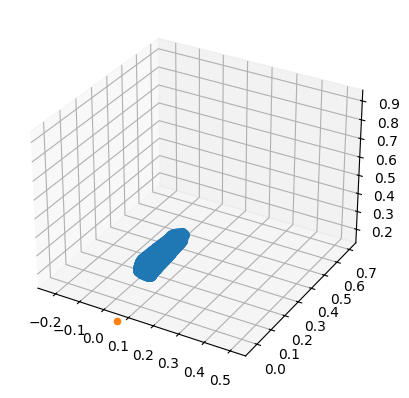

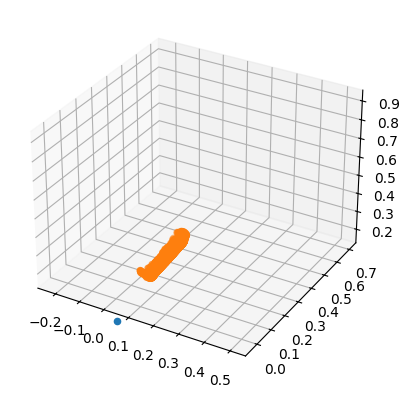

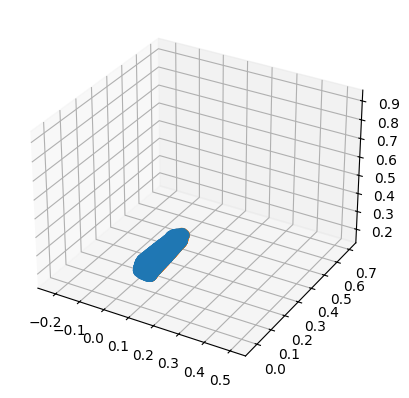

In [7]:
TEST_ICP = True
if TEST_ICP:

    selection = 2, 1, 1
    scene = data[selection]


    rgb = scene["color"]() * 255
    depth = scene["depth"]() / 1000
    label = scene["label"]()
    meta = scene["meta"]

    item = 0
    obj_id = meta["object_ids"][item]
    scale, translate = None, None

    MAX_SAMPLES = 4_000
    mask = label == obj_id
    target_size = None # (432, 768)
    margin = 12
    aspect_ratio = False
    mask_fill = False

    (rgb, depth, mask), scale, translate = crop_and_resize_multiple(
        (rgb, depth, mask), mask, target_size=target_size, margin=margin, 
        aspect_ratio=aspect_ratio, mask_fill=mask_fill)
    
    print(scale, translate)

    target_pcd = back_project(depth, meta, mask, (scale, translate))

    samples = min(len(target_pcd), MAX_SAMPLES)
    if samples == MAX_SAMPLES:
        sample_indices = np.linspace(start=0, stop=len(target_pcd)-1, num=samples, dtype=int)

        target_pcd = target_pcd[sample_indices]

    # indices = np.where(label == obj_id)
    # obj_pnts = back_projection[indices]
    # obj_rgb = rgb[indices]

    mesh = data.get_mesh(obj_id)
    source_pcd, faces = trimesh.sample.sample_surface(mesh, MAX_SAMPLES)

    source_pcd = source_pcd * meta["scales"][obj_id]
    target_pcd = target_pcd # / meta["scales"][obj_id] # Back Projected

    print(meta["object_names"])

    camera_scale = 0.2
    camera_translate = np.mean(target_pcd, axis=0)

    attempts = 10
    # Visualization
    T = icp(source_pcd, target_pcd, attempts=attempts)

    print(T)
    gt_T = meta["poses_world"][obj_id]
    print(gt_T)
    print("")

    rre = np.rad2deg(compute_rre(T[:3, :3], gt_T[:3, :3]))
    rte = compute_rte(T[:3, 3], gt_T[:3, 3])
    print(f"rre={rre}, rte={rte}")

    compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], target_pcd, scale=camera_scale, translate=camera_translate)

    # These are individual plots and will also point at the origin (stray points)
    compare_points(source_pcd @ T[:3, :3].T + T[:3, 3], np.zeros((1, 3)), scale=camera_scale, translate=camera_translate)
    compare_points(np.zeros((1, 3)), target_pcd, scale=camera_scale, translate=camera_translate)

    compare_points(source_pcd @ gt_T[:3, :3].T + gt_T[:3, 3], target_pcd,  scale=camera_scale, translate=camera_translate)

assert 0


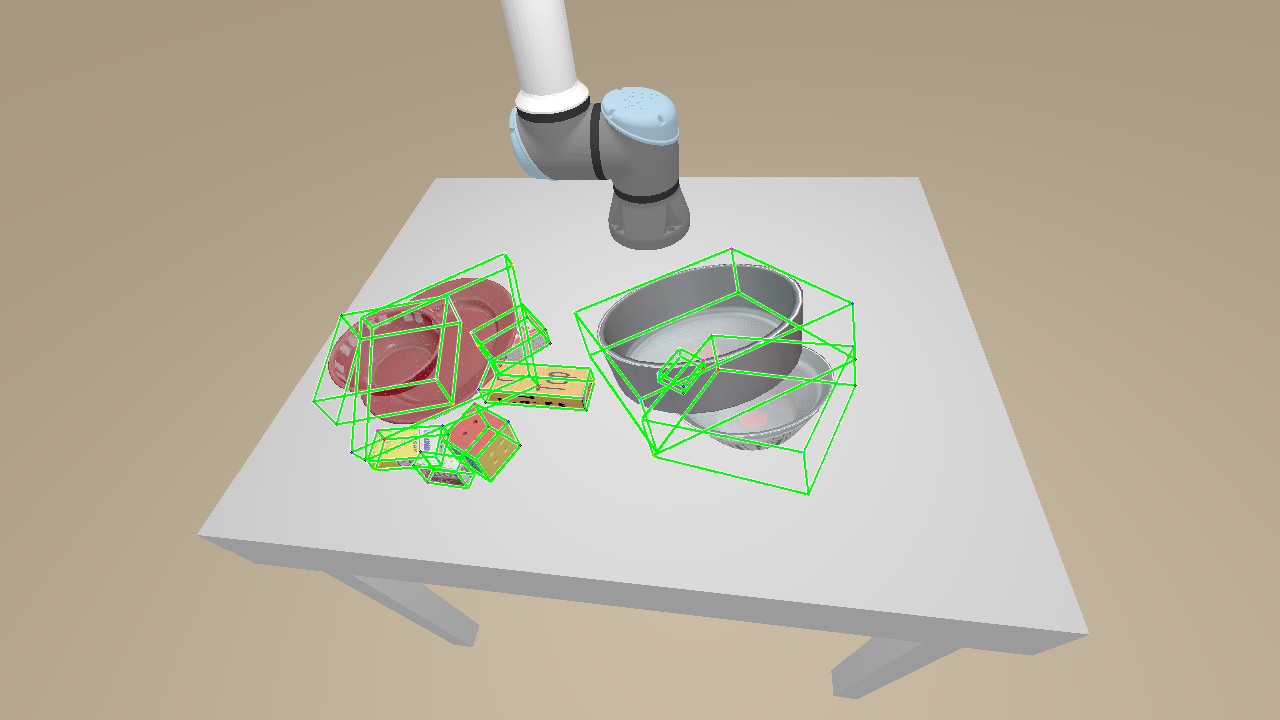

In [ ]:
from pose_estimation import draw_projected_box3d

poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])

boxed_image = np.array(rgb)
for i in range(len(poses_world)):
    draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))


In [ ]:
ICP_RUN = True
if ICP_RUN:
    data = PoseData(TEST_PATH, MODELS_PATH)

    MESH_SAMPLES = None
    ICP_ATTEMPTS = 10

    results = {}
    print(len(data))
    for i, key in enumerate(data.keys()):

        print(i, key)

        l, s, v = key

        scene = data[key]

        rgb = scene["color"]() * 255
        depth = scene["depth"]() / 1000
        label = scene["label"]()
        meta = scene["meta"]
        
        back_projection = back_project(depth, meta)

        world_frames = [None] * 79

        object_ids = [object_id for object_id in np.unique(label) if object_id < 79]

        for object_id in object_ids:

            indices = np.where(label == object_id)
            obj_pnts = back_projection[indices]
            obj_rgb = rgb[indices]

            mesh = data.get_mesh(object_id)
            source_pcd, faces = trimesh.sample.sample_surface(mesh, len(obj_pnts) if MESH_SAMPLES in [-1, 0, None, False] else MESH_SAMPLES)

            source_pcd = source_pcd * meta["scales"][object_id]
            target_pcd = obj_pnts

            T = icp(source_pcd, target_pcd, attempts=ICP_ATTEMPTS)

            world_frames[object_id] = T.tolist()

            results[f"{l}-{s}-{v}"] = {"poses_world" : world_frames}


200
0 (1, 19, 1)
1 (2, 88, 1)
2 (1, 85, 1)
3 (1, 72, 1)
4 (1, 45, 1)
5 (1, 20, 1)
6 (1, 88, 1)
7 (1, 14, 1)
8 (2, 63, 1)
9 (1, 77, 1)
10 (1, 10, 1)
11 (1, 43, 1)
12 (1, 27, 1)
13 (2, 14, 1)
14 (1, 2, 1)


KeyboardInterrupt: 

In [ ]:
data_npz = PoseDataNPZ(TRAIN_NPZ_PATH)

print(len(data_npz))


In [ ]:
dataset = PoseDataset(TRAIN_PATH, MODELS_PATH, mesh_samples=20_000)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

print(len(dataset))

for i, (s, t, p, e) in enumerate(data_loader):

    index = e[0].int().item()
    key = tuple(torch.tensor(e[2]).tolist())

    rgb = dataset.rgbs[key]
    depth = dataset.depths[key]
    label = dataset.labels[key]

    print(key)
    print(np.unique(label))

    print(t.shape)

    indices = dataset.indices[index]

    crop = crop_image_using_segmentation(rgb, indices)

    # plt.figure(figsize=(15, 10))
    # plt.subplot(1, 3, 1)
    # plt.imshow(rgb)
    # plt.figure(figsize=(15, 10))
    # plt.subplot(1, 3, 1)
    # plt.imshow(crop)
    # plt.figure(figsize=(15, 10))
    # plt.subplot(1, 3, 1)
    # plt.imshow(rgb[indices])

    # assert 0

        
    


In [ ]:



T = icp(source_pcd, target_pcd, attempts=ICP_ATTEMPTS)

world_frames[object_id] = T.tolist()

results[f"{l}-{s}-{v}"] = {"poses_world" : world_frames}


In [ ]:
import json
with open("results.json", "w") as f:
    json.dump(results, f)
